# Bank Churn ML

Imports

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sn
import matplotlib.pyplot as plt
import copy

### Load Data

- Order of Operations
  - Load Customer Dataset
  - Perform necessary Customer Dataset cleaning
  - Convert Customer Dataset to transactional rows
  - Load Transactional Dataset
  - Append transactional Customer Dataset to top of Transactional Dataset

In [3]:
# Load customer dataset
c_df_original = pd.read_csv(r"C:\bank-churn-data\customers_tm1_e.csv")
c_df_original['start_balance'] = c_df_original['start_balance'].apply(lambda x: 0 if pd.isna(x) else x)
c_df_original.loc[c_df_original['start_balance'] < 0,'start_balance'] = 0
c_df_original.loc[c_df_original['start_balance'] >10000000,'start_balance'] = 0
c_df = c_df_original[:1000]
c_array = c_df.to_numpy()

# Convert customer data to transactional rows
c_to_t = pd.DataFrame()
c_to_t['date'] = c_df_original['creation_date']
c_to_t['account_id'] = 0
c_to_t['customer_id'] = c_df_original['customer_id']
c_to_t['amount'] = c_df_original['start_balance']
c_to_t['transaction_date'] = c_df_original['creation_date']
c_to_t['deposit'] = c_df_original['start_balance']#.apply(lambda x: 0 if pd.isna(x) else x)
c_to_t['withdrawal'] = 0

# Load transactional dataset
t_df_original = pd.read_csv(r"C:\bank-churn-data\transactions_tm1_e.csv")
t_df_original = pd.concat([c_to_t, t_df_original])
t_df = t_df_original.iloc[:1000]
t_array = t_df.to_numpy()
display(c_df_original)



,customer_id,dob,state,start_balance,creation_date
0,91,1993-07-01,California,10180.56,2007-01-31
1,92,1985-12-05,New York,4757.68,2007-01-31
2,93,1987-11-19,Minnesota,6796.72,2007-01-31
3,94,1981-03-23,Minnesota,9870.48,2007-01-31
4,95,1970-04-06,California,12500.72,2007-01-31
...,...,...,...,...,...
116011,116102,1969-03-02,Georgia,3110.96,2020-05-31
116012,116103,1966-10-25,New York,12063.92,2020-05-31
116013,116104,1986-04-30,Oklahoma,11011.36,2020-05-31
116014,116105,1983-08-25,New Mexico,8861.08,2020-05-31


### Profiling the Datasets

In [4]:
# Shows missing values per column of each dataset
missing_t_df = t_df_original.isna()
missing_c_df = c_df_original.isna()
missing_t = missing_t_df.sum(axis=0)
missing_c = missing_c_df.sum(axis=0)
print(missing_t)
print(missing_c)
missing_c_starting_balance = c_df_original['start_balance'].isna()
display(c_df_original.loc[missing_c_starting_balance])
print(c_to_t['deposit'].isna().sum())
display(c_to_t)

date                0
account_id          0
customer_id         0
amount              0
transaction_date    0
deposit             0
withdrawal          0
dtype: int64
customer_id      0
dob              0
state            0
start_balance    0
creation_date    0
dtype: int64


,customer_id,dob,state,start_balance,creation_date


0


,date,account_id,customer_id,amount,transaction_date,deposit,withdrawal
0,2007-01-31,0,91,10180.56,2007-01-31,10180.56,0
1,2007-01-31,0,92,4757.68,2007-01-31,4757.68,0
2,2007-01-31,0,93,6796.72,2007-01-31,6796.72,0
3,2007-01-31,0,94,9870.48,2007-01-31,9870.48,0
4,2007-01-31,0,95,12500.72,2007-01-31,12500.72,0
...,...,...,...,...,...,...,...
116011,2020-05-31,0,116102,3110.96,2020-05-31,3110.96,0
116012,2020-05-31,0,116103,12063.92,2020-05-31,12063.92,0
116013,2020-05-31,0,116104,11011.36,2020-05-31,11011.36,0
116014,2020-05-31,0,116105,8861.08,2020-05-31,8861.08,0


In [5]:
# Prints column names and the lake for ease of reference
print(t_df.columns,'\n',t_array[:2],'\n\n',c_df.columns,'\n',c_array[:2])

Index(['date', 'account_id', 'customer_id', 'amount', 'transaction_date',
       'deposit', 'withdrawal'],
      dtype='object') 
 [['2007-01-31' 0 91 10180.56 '2007-01-31' 10180.56 0.0]
 ['2007-01-31' 0 92 4757.68 '2007-01-31' 4757.68 0.0]] 

 Index(['customer_id', 'dob', 'state', 'start_balance', 'creation_date'], dtype='object') 
 [[91 '1993-07-01' 'California' 10180.56 '2007-01-31']
 [92 '1985-12-05' 'New York' 4757.68 '2007-01-31']]


In [6]:
# Code I ran to show that each customer_id has only 1 account_id
ex_df = t_df_original.groupby('customer_id')['account_id'].nunique()
display(ex_df)
display(type(ex_df))
display(ex_df.max())

customer_id
91        2
92        2
93        2
94        2
95        2
         ..
116102    2
116103    2
116104    2
116105    2
116106    2
Name: account_id, Length: 116016, dtype: int64

pandas.core.series.Series

2

### Transformations

Features to add list:
- From transactions, groupby(['account_id', month('transaction_date')])
  - sum(deposit) in month ~ total deposited
  - sum(withdrawal) in month ~ total withdrawn
  - sum(amount) in month ~ total delta
  - count(deposit != 0) in month ~ total deposits
  - count(withdrawal != 0) in month ~ total withdrawals
  - count(amount != 0) in month ~ total transactions
  - month('transaction_date') - {customer_id:dob} ~ age of customer at given time
  - month('transaction_date') - {customer_id:creation_date} ~ age of account at given time
  - cumsum(amount) ~ total in account at end of month
  - 'transaction_date' - df['transaction_date'].shift(1)~ Period of time between this transaction and next transaction (or with 6/1/2020)
  - ? Whether there was a no-amount transaction? Would those be interpreted as just balance checks?

- From customers (also have to factor in having multiple accounts):
  - initials['customer_id', 'start_balance']
  - ~ time since last transaction
  - ~ current age
  - ~ current age of account
  - ~ current account balance
  - ~ last transaction amount
  - ~ period of time between first and last transaction (+ activity rate)
  - ~ total number of withdrawals made (+ ratio over time)
  - ~ total number of deposits made (+ ratio over time)
  - ~ Number of 

- ideas
  - transactional data must be analyzed in a time-series manner while customer data would be through a more standard logistical model?
  - People with many accounts will be more likely to close AN account (1 of them) since they have other accounts usable
    - People with only 1 account will be less likely to close their account
  - look if a certain quantity of withdrawal (amount, proportion of account) in a given month correlates with churning
    - for example, if they withdrawal X% of their account (which may be associated with subsequent inactivity) => churn
  - Period of time between this transaction and next transaction (or with 6/1/2020)
    - naturally older churned accounts will have a much higher forward inactivity value.
    - What's the average of churned and un-churned accounts and how well does one forward inactivity value distinguish between them
  - Someone who deposits more than they withdrawal in general probably is not churning over a long enough timespan?
    - big withdrawals should be counted for more tho since an account may get filled steadily but being brought down to 0 should be more significant
    - So must be combined with info on final account value
  - 
  - 


In [22]:
# Adds a month and year date columns and binary columns to check if the transaction
# was a deposit, withdrawal, or check_balance (?, a transaction with amount=0) occurred on each line
    # The binary column will be used in group summation to find # of deposits and withdrawals per month

t_df_original['transaction_date'] = t_df_original['transaction_date'].apply(pd.to_datetime)
t_df_original = t_df_original.sort_values(by=['customer_id', 'transaction_date'])
t_df_original['month'] = t_df_original['transaction_date'].dt.month
t_df_original['year'] = t_df_original['transaction_date'].dt.year
t_df_original['amount'] = t_df_original['deposit'] + t_df_original['withdrawal']
t_df_original['deposit_y'] = t_df_original['deposit'].apply(lambda x: 1 if abs(x) > 0 else 0)
t_df_original['withdrawal_y'] = t_df_original['withdrawal'].apply(lambda x: 1 if abs(x) > 0 else 0)
t_df_original['checked_balance'] = t_df_original['amount'].apply(lambda x: 1 if abs(x) == 0 else 0)
t_df_original['time_since_last_trans'] = t_df_original.groupby('customer_id')['transaction_date'].diff()
t_df_original['time_since_last_trans_in_days'] = t_df_original['time_since_last_trans'].dt.total_seconds()/(60*60*24)
t_df_original['running_balance'] = t_df_original.groupby('customer_id')['amount'].cumsum()

# Adding binary indicator if transaction occured in final 3 months
temp_df = t_df_original.groupby('customer_id').agg(last_date=('transaction_date','max'))
t_df_original = t_df_original.merge(temp_df, how='inner', on='customer_id')
t_df_original['3m_mark'] = t_df_original['last_date'] + pd.Timedelta(-91, 'd')
t_df_original['last_3_months'] = (t_df_original['transaction_date'] >=
                                  t_df_original['3m_mark']
                                  ).replace({True:1, False:0})
t_df_original = t_df_original.drop(columns=[ '3m_mark', 'last_date'])

display(t_df_original)

,date,account_id,customer_id,amount,transaction_date,deposit,withdrawal,month,year,deposit_y,withdrawal_y,checked_balance,time_since_last_trans,time_since_last_trans_in_days,running_balance,last_3_months
0,2007-01-31,24137947,91,-5295.18,2007-01-16,0.00,-5295.18,1,2007,0,1,0,NaT,NaN,-5295.18,1
1,2007-01-31,0,91,10180.56,2007-01-31,10180.56,0.00,1,2007,1,0,0,15 days,15.0,4885.38,1
2,2007-01-31,24137947,91,3034.26,2007-01-31,3034.26,0.00,1,2007,1,0,0,0 days,0.0,7919.64,1
3,2007-02-28,24137947,91,0.00,2007-02-28,0.00,0.00,2,2007,0,0,1,28 days,28.0,7919.64,1
4,2007-03-31,24137947,91,0.00,2007-03-11,0.00,-0.00,3,2007,0,0,1,11 days,11.0,7919.64,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5093983,2020-05-31,24253960,116104,2900.20,2020-05-31,2900.20,0.00,5,2020,1,0,0,0 days,0.0,9909.26,1
5093984,2020-05-31,0,116105,8861.08,2020-05-31,8861.08,0.00,5,2020,1,0,0,NaT,NaN,8861.08,1
5093985,2020-05-31,24253961,116105,2246.93,2020-05-31,2246.93,0.00,5,2020,1,0,0,0 days,0.0,11108.01,1
5093986,2020-05-31,0,116106,201.32,2020-05-31,201.32,0.00,5,2020,1,0,0,NaT,NaN,201.32,1


In [8]:
# Adding binary indicator if transaction occured in final 3 months
# t_df_original['3m_mark'] = 0
# t_df_original['last_3_months'] = 0
# t_df_original = t_df_original.drop(columns=[ '3m_mark', 'last_3_months'])
# last_ts = t_df_original.groupby('customer_id').agg(last_date=('transaction_date','max'))
# last_ts = t_df_original.merge(last_ts, how='inner', on='customer_id')
# last_ts['3m_mark'] = last_ts['last_date'] + pd.Timedelta(-91, 'd')
# last_ts['last_3_months'] = (last_ts['transaction_date'] >=
#                                   last_ts['3m_mark']
#                                   ).replace({True:1, False:0})

# display(last_ts[last_ts['last_3_months'] == 0])


In [9]:
# Group by customer_id, year, month
# Creates sum_deposit, sum_withdrawal, sum_amount per month
# and count_deposit and count_withdrawal (counts number of each per month)
# and binary check if the customer checked their balance
# Adds mean of deposits and withdrawals in each month and the running balance at end of month

t_df_grouped = t_df_original.groupby(
    ["customer_id","year","month"])['amount','deposit','withdrawal', 'deposit_y','withdrawal_y',
                                    'time_since_last_trans_in_days', 'checked_balance'].agg(
    sum_deposit = ("deposit","sum"),
    sum_withdrawal = ("withdrawal","sum"),
    count_deposit = ("deposit_y", "sum"),
    count_withdrawal = ("withdrawal_y", 'sum'),
    checked_balance = ("checked_balance",'max'),
    mean_time_between_trans = ("time_since_last_trans_in_days", "mean")
)

t_df_grouped['sum_delta'] = t_df_grouped['sum_deposit'] + t_df_grouped['sum_withdrawal']
t_df_grouped['mean_deposit'] = (
    t_df_grouped['sum_deposit']/t_df_grouped['count_deposit'].apply(lambda x:max(1,x)))
t_df_grouped['mean_withdrawal'] = (
    t_df_grouped['sum_withdrawal']/t_df_grouped['count_withdrawal'].apply(lambda x:max(1,x)))

t_df_grouped['running_balance'] = t_df_grouped.groupby('customer_id')['sum_delta'].cumsum()
display(t_df_grouped)



C:\Users\EdwinSantos\AppData\Local\Temp\ipykernel_2676\1414584712.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  t_df_grouped = t_df_original.groupby(


sum_deposit  sum_withdrawal  count_deposit  \
customer_id year month                                               
91          2007 1         13214.82        -5295.18              2   
                 2             0.00            0.00              0   
                 3             0.00            0.00              0   
92          2007 1          4757.68            0.00              1   
                 2          1164.90            0.00              1   
...                             ...             ...            ...   
116102      2020 5          3983.95        -1223.94              2   
116103      2020 5         15418.32        -4357.62              2   
116104      2020 5         13911.56        -4002.30              2   
116105      2020 5         11108.01            0.00              2   
116106      2020 5           258.31            0.00              2   

                        count_withdrawal  checked_balance  \
customer_id year month                                      
91          2007 1                     1                0   
                 2                     0                1   
                 3                     0                1   
92          2007 1                     0                1   
                 2                     0                0   
...                                  ...              ...   
116102      2020 5                     1                0   
116103      2020 5                     2                0   
116104      2020 5                     1                0   
116105      2020 5                     0                0   
116106      2020 5                     0                0   

                        mean_time_between_trans  sum_delta  mean_deposit  \
customer_id year month                                                     
91          2007 1                     7.500000    7919.64      6607.410   
                 2                    28.000000       0.00         0.000   
                 3                    10.000000       0.00         0.000   
92          2007 1                     0.000000    4757.68      4757.680   
                 2                    28.000000    1164.90      1164.900   
...                                         ...        ...           ...   
116102      2020 5                     9.500000    2760.01      1991.975   
116103      2020 5                     7.333333   11060.70      7709.160   
116104      2020 5                     1.000000    9909.26      6955.780   
116105      2020 5                     0.000000   11108.01      5554.005   
116106      2020 5                     0.000000     258.31       129.155   

                        mean_withdrawal  running_balance  
customer_id year month                                    
91          2007 1             -5295.18          7919.64  
                 2                 0.00          7919.64  
                 3                 0.00          7919.64  
92          2007 1                 0.00          4757.68  
                 2                 0.00          5922.58  
...                                 ...              ...  
116102      2020 5             -1223.94          2760.01  
116103      2020 5             -2178.81         11060.70  
116104      2020 5             -4002.30          9909.26  
116105      2020 5                 0.00         11108.01  
116106      2020 5                 0.00           258.31  

[2129121 rows x 10 columns]

Create transactional rows based off customer dataset rows (Box below complete)

Summary Stats for Customer Dataset

In [26]:
c_summary = t_df_original.groupby(
    "customer_id")[['deposit','withdrawal', 'deposit_y', 'withdrawal_y','checked_balance',
                   'transaction_date','time_since_last_trans_in_days', 'last_3_months']].agg(
    total_deposits = ("deposit","sum"),
    total_withdrawals = ("withdrawal","sum"),
    num_deposit = ("deposit_y", "sum"),
    num_withdrawal = ("withdrawal_y", 'sum'),
    num_checked_balance = ("checked_balance",'max'),
    num_transactions = ('deposit','count'),
    first_transaction = ('transaction_date','first'),
    last_transaction = ('transaction_date','last'),
    mean_time_between_trans_in_days = ('time_since_last_trans_in_days','mean'),
    transactions_during_last_3m = ('last_3_months', 'sum')
                   )

#c_summary['final_balance'] = c_summary['total_deposits'] + c_summary['total_withdrawals']
# act_lifespan - lifespan of account, time from first transaction to last transaction
c_summary['act_lifespan_in_days'] = c_summary['last_transaction'] - c_summary['first_transaction']
c_summary['act_lifespan_in_days'] = c_summary['act_lifespan_in_days'].dt.total_seconds()/(60*60*24) + 1
# time_since_last_trans - time between 2020-06-01 (end of data window) and last transaction of customer
c_summary['time_since_last_trans_in_days'] = pd.to_datetime('2020-06-01') - c_summary['last_transaction']
c_summary['time_since_last_trans_in_days'] = c_summary['time_since_last_trans_in_days'].dt.total_seconds()/(60*60*24)
c_summary['transactional_rate_lifetime'] = c_summary['num_transactions']/c_summary['act_lifespan_in_days']
# Features for last 3 months
c_summary['t_rate_last_3m'] = c_summary['transactions_during_last_3m']/91
c_summary['t_rate_last_3m_over_lifetime']= c_summary['t_rate_last_3m']/c_summary['transactional_rate_lifetime']
c_summary['t_in_last_3m'] = (c_summary['last_transaction'] > (pd.to_datetime('2020-06-01') + pd.Timedelta(-91,"d"))).replace(
    {True:1,False:0})
c_summary = c_summary.reset_index()

last_3m_balances = t_df_original[t_df_original['last_3_months'] == 1].groupby(
    'customer_id')[['amount', 'running_balance']].agg(
        first_amount_of_3m = ('amount', 'first'),
        first_rb_of_3m = ('running_balance', 'first'),
        final_balance = ('running_balance', 'last')
    )
last_3m_balances = last_3m_balances.reset_index()
last_3m_balances['delta_last_3m'] = (last_3m_balances['final_balance']
                                        + last_3m_balances['first_amount_of_3m']
                                        - last_3m_balances['first_rb_of_3m'])
last_3m_balances['saved_last_3m'] = (last_3m_balances['delta_last_3m'] > 0).replace({True: 1, False:0})
c_summary = c_summary.merge(last_3m_balances[['customer_id', 'delta_last_3m',
                                              'saved_last_3m', 'final_balance']],
                            how='inner', on='customer_id')

# Creating full dataframe summarizing customer features
c_combined = c_df_original.merge(c_summary, how='inner', on='customer_id')
c_combined['age_at_last_trans'] = c_combined['last_transaction'] - c_combined['dob'].apply(pd.to_datetime)
c_combined['age_at_last_trans'] = c_combined['age_at_last_trans'].dt.total_seconds()/(60*60*24*365)
c_combined['churned'] = (c_combined['last_transaction'] <= pd.to_datetime('2019-12-01')).replace({True:1, False:0})


display(c_combined)

,customer_id,dob,state,start_balance,creation_date,total_deposits,total_withdrawals,num_deposit,num_withdrawal,num_checked_balance,...,time_since_last_trans_in_days,transactional_rate_lifetime,t_rate_last_3m,t_rate_last_3m_over_lifetime,t_in_last_3m,delta_last_3m,saved_last_3m,final_balance,age_at_last_trans,churned
0,91,1993-07-01,California,10180.56,2007-01-31,13214.82,-5295.18,2,1,1,...,4812.0,0.094595,0.076923,0.813187,0,7919.64,1,7919.64,13.753425,1
1,92,1985-12-05,New York,4757.68,2007-01-31,18049.77,-7629.15,11,16,1,...,4462.0,0.078240,0.043956,0.561813,0,1418.64,1,10420.62,22.287671,1
2,93,1987-11-19,Minnesota,6796.72,2007-01-31,26619.33,-18965.15,11,19,0,...,4567.0,0.098684,0.131868,1.336264,0,-3202.50,0,7654.18,20.043836,1
3,94,1981-03-23,Minnesota,9870.48,2007-01-31,27674.87,-16791.91,7,18,1,...,4597.0,0.111842,0.043956,0.393019,0,0.00,0,10882.96,26.624658,1
4,95,1970-04-06,California,12500.72,2007-01-31,73832.84,-48886.87,18,26,1,...,4292.0,0.082902,0.032967,0.397665,0,3544.79,1,24945.97,38.430137,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116011,116102,1969-03-02,Georgia,3110.96,2020-05-31,3983.95,-1223.94,2,1,0,...,1.0,0.150000,0.032967,0.219780,1,2760.01,1,2760.01,51.282192,0
116012,116103,1966-10-25,New York,12063.92,2020-05-31,15418.32,-4357.62,2,2,0,...,1.0,0.173913,0.043956,0.252747,1,11060.70,1,11060.70,53.635616,0
116013,116104,1986-04-30,Oklahoma,11011.36,2020-05-31,13911.56,-4002.30,2,1,0,...,1.0,1.000000,0.032967,0.032967,1,9909.26,1,9909.26,34.109589,0
116014,116105,1983-08-25,New Mexico,8861.08,2020-05-31,11108.01,0.00,2,0,0,...,1.0,2.000000,0.021978,0.010989,1,11108.01,1,11108.01,36.791781,0


In [20]:
last_3m_balances = t_df_original[t_df_original['last_3_months'] == 1].groupby(
    'customer_id')[['amount', 'running_balance']].agg(
        first_amount_of_3m = ('amount', 'first'),
        first_rb_of_3m = ('running_balance', 'first'),
        last_rb_of_3m = ('running_balance', 'last')
    )
last_3m_balances = last_3m_balances.reset_index()
last_3m_balances['delta_in_3m'] = (last_3m_balances['last_rb_of_3m']
                                        + last_3m_balances['first_amount_of_3m']
                                        - last_3m_balances['first_rb_of_3m'])
last_3m_balances['saved_in_3m'] = (last_3m_balances['delta_in_3m'] > 0).replace({True: 1, False:0})

display(last_3m_balances)

,customer_id,first_amount_of_3m,first_rb_of_3m,last_rb_of_3m,delta_in_3m,saved_in_3m
0,91,-5295.18,-5295.18,7919.64,7919.64,True
1,92,1418.64,10420.62,10420.62,1418.64,True
2,93,1946.19,12802.87,7654.18,-3202.50,False
3,94,0.00,10882.96,10882.96,0.00,False
4,95,0.00,21401.18,24945.97,3544.79,True
...,...,...,...,...,...,...
116011,116102,-1223.94,-1223.94,2760.01,2760.01,True
116012,116103,-1301.43,-1301.43,11060.70,11060.70,True
116013,116104,-4002.30,-4002.30,9909.26,9909.26,True
116014,116105,8861.08,8861.08,11108.01,11108.01,True


In [12]:
test_last_3m = t_df_original.groupby(by=['customer_id'])[['last_3_months', 'transaction_date']].agg(
    t_in_last_3m = ('last_3_months', "sum"),
    t_total = ('last_3_months', "count"),
    t_first = ('transaction_date', 'first'),
    t_last = ('transaction_date', 'last')
)
test_last_3m = test_last_3m.reset_index()
test_last_3m['t_rate_last_3m'] = test_last_3m['t_in_last_3m']/91
display(test_last_3m)


,customer_id,t_in_last_3m,t_total,t_first,t_last,t_rate_last_3m
0,91,7,7,2007-01-16,2007-03-30,0.076923
1,92,4,32,2007-01-31,2008-03-14,0.043956
2,93,12,30,2007-01-31,2007-11-30,0.131868
3,94,4,34,2007-01-01,2007-10-31,0.043956
4,95,3,48,2007-01-31,2008-08-31,0.032967
...,...,...,...,...,...,...
116011,116102,3,3,2020-05-12,2020-05-31,0.032967
116012,116103,4,4,2020-05-09,2020-05-31,0.043956
116013,116104,3,3,2020-05-29,2020-05-31,0.032967
116014,116105,2,2,2020-05-31,2020-05-31,0.021978


In [13]:
customers_elt_30 = c_combined.loc[c_combined['act_lifespan_in_days']<= 30]
display(customers_elt_30)
print(len(customers_elt_30)/len(c_combined))

,customer_id,dob,state,start_balance,creation_date,total_deposits,total_withdrawals,num_deposit,num_withdrawal,num_checked_balance,num_transactions,first_transaction,last_transaction,mean_time_between_trans_in_days,final_balance,act_lifespan_in_days,time_since_last_trans_in_days,transactional_rate,age_at_last_trans,churned
11,102,1981-12-24,Florida,8718.24,2007-01-31,11383.67,0.00,2,0,1,3,2007-01-31,2007-02-15,7.500000,11383.67,16.0,4855.0,0.187500,25.161644,1
90,181,1990-05-07,California,646.68,2007-01-31,1019.42,-317.85,3,2,0,5,2007-01-31,2007-02-28,7.000000,701.57,29.0,4842.0,0.172414,16.824658,1
170,261,1965-03-11,Oklahoma,10437.32,2007-01-31,13233.87,-4936.17,2,2,0,4,2007-01-20,2007-01-31,3.666667,8297.70,12.0,4870.0,0.333333,41.920548,1
257,348,1980-05-26,Georgia,8442.44,2007-01-31,10964.47,-4211.10,2,2,0,4,2007-01-17,2007-01-31,4.666667,6753.37,15.0,4870.0,0.266667,26.701370,1
334,425,1973-05-22,Pennsylvania,9303.80,2007-01-31,12085.64,-5064.11,2,1,0,3,2007-01-31,2007-01-31,0.000000,7021.53,1.0,4870.0,3.000000,33.717808,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116011,116102,1969-03-02,Georgia,3110.96,2020-05-31,3983.95,-1223.94,2,1,0,3,2020-05-12,2020-05-31,9.500000,2760.01,20.0,1.0,0.150000,51.282192,0
116012,116103,1966-10-25,New York,12063.92,2020-05-31,15418.32,-4357.62,2,2,0,4,2020-05-09,2020-05-31,7.333333,11060.70,23.0,1.0,0.173913,53.635616,0
116013,116104,1986-04-30,Oklahoma,11011.36,2020-05-31,13911.56,-4002.30,2,1,0,3,2020-05-29,2020-05-31,1.000000,9909.26,3.0,1.0,1.000000,34.109589,0
116014,116105,1983-08-25,New Mexico,8861.08,2020-05-31,11108.01,0.00,2,0,0,2,2020-05-31,2020-05-31,0.000000,11108.01,1.0,1.0,2.000000,36.791781,0


0.04928630533719487


As the above cell shows, there is only 1 client (customer_id=37914) who has no deposit or withdrawals on record (only check balances). In order to create a feature involving number/value of withdrawals over number/value of deposits, it will be necessary to drop the below client since their account has minimal value in terms of our analysis and will not significantly alter the integrity of our dataset.

In [14]:
display(c_combined[c_combined['num_deposit']==0])

,customer_id,dob,state,start_balance,creation_date,total_deposits,total_withdrawals,num_deposit,num_withdrawal,num_checked_balance,num_transactions,first_transaction,last_transaction,mean_time_between_trans_in_days,final_balance,act_lifespan_in_days,time_since_last_trans_in_days,transactional_rate,age_at_last_trans,churned
37823,37914,1978-07-10,North Carolina,0.0,2011-10-31,0.0,0.0,0,0,1,4,2011-10-31,2011-12-31,20.333333,0.0,62.0,3075.0,0.064516,33.49863,1


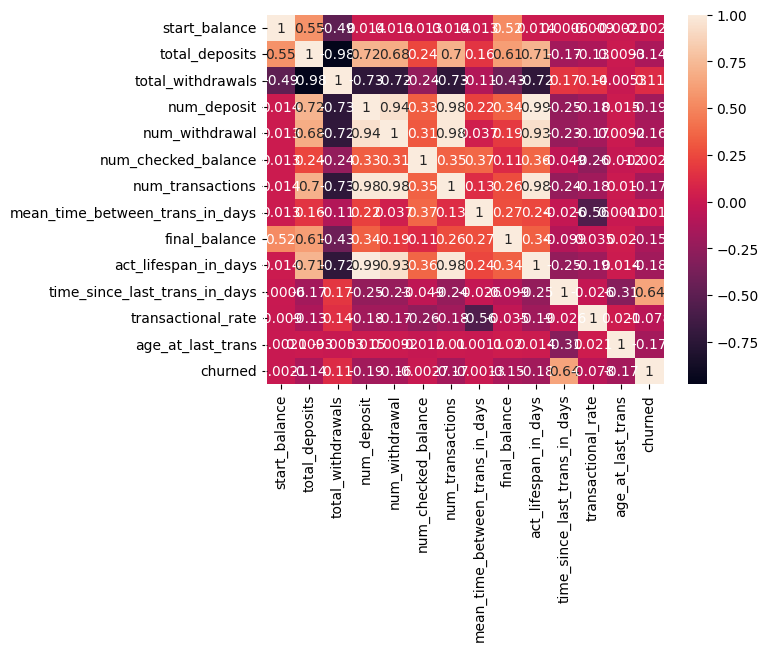

In [15]:
c_corr = c_combined.drop(columns=['dob', 'state', 'customer_id', 'creation_date', 'first_transaction',
                                  'last_transaction'])
sn.heatmap(c_corr.corr(), annot = True)
plt.show()

Below tests different month thresholds for churn labelling (6/9/12 months).
Between 6 and 12 months, there is only a 3% difference. The lower month threshold was chosen to be more sensitive to churning.

In [18]:
c_combined['churned_6'] = c_combined['last_transaction'].apply(lambda x: 1 if x <= pd.to_datetime('2019-12-01') else 0)
c_combined['churned_9'] = c_combined['last_transaction'].apply(lambda x: 1 if x <= pd.to_datetime('2019-09-01') else 0)
c_combined['churned_12'] = c_combined['last_transaction'].apply(lambda x: 1 if x <= pd.to_datetime('2019-06-01') else 0)
print('6: ', c_combined['churned_6'].sum()*100/len(c_combined['churned_6']), '%')
print('9: ', c_combined['churned_9'].sum()*100/len(c_combined['churned_9']), '%')
print('12: ', c_combined['churned_12'].sum()*100/len(c_combined['churned_12']), '%')

6:  81.92059715901254 %
9:  80.41390842642394 %
12:  78.9451454971728 %
